In [1]:
import os, glob
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

PROJECT_ROOT = Path(r"C:\Users\aibel\OneDrive\Desktop\Heizel Ann Joseph\Parkinsons Disease")
DATA_ROOT = PROJECT_ROOT / "data" / "PaHaW_dataset"
PAHAW_PUBLIC = DATA_ROOT / "PaHaW_public"

print("PROJECT_ROOT exists:", PROJECT_ROOT.exists())
print("PAHAW_PUBLIC exists:", PAHAW_PUBLIC.exists())


PROJECT_ROOT exists: True
PAHAW_PUBLIC exists: True


In [2]:
def load_svc(path):
    rows = []
    with open(path, "r", errors="ignore") as f:
        for ln in f:
            parts = ln.strip().split()
            if len(parts) >= 7:
                try:
                    y, x, t, pen, az, alt, pr = parts[:7]
                    rows.append([
                        float(x),
                        float(y),
                        float(t),
                        int(float(pen)),
                        float(az),
                        float(alt),
                        float(pr)
                    ])
                except:
                    continue

    df = pd.DataFrame(
        rows,
        columns=["x", "y", "time", "pen", "azim", "alt", "press"]
    )

    if len(df) == 0:
        return df

    df["time"] = df["time"] - df["time"].iloc[0]
    return df


In [3]:
def preprocess_df(df):
    df = df.copy().reset_index(drop=True)

    # -----------------------------
    # Time handling
    # -----------------------------
    df["time_s"] = df["time"]
    df["dt"] = df["time_s"].diff().fillna(1e-3)
    df.loc[df["dt"] <= 0, "dt"] = 1e-3

    # -----------------------------
    # Center y (writing baseline)
    # -----------------------------
    df["y"] = df["y"] - df["y"].mean()

    # -----------------------------
    # Smooth coordinates
    # -----------------------------
    if len(df) >= 7:
        df["x_s"] = savgol_filter(df["x"], 7, 2)
        df["y_s"] = savgol_filter(df["y"], 7, 2)
    else:
        df["x_s"] = df["x"]
        df["y_s"] = df["y"]

    # -----------------------------
    # Velocity
    # -----------------------------
    df["vx"] = df["x_s"].diff().fillna(0) / df["dt"]
    df["vy"] = df["y_s"].diff().fillna(0) / df["dt"]
    df["speed"] = np.sqrt(df["vx"]**2 + df["vy"]**2)

    # -----------------------------
    # Acceleration
    # -----------------------------
    df["ax"] = df["vx"].diff().fillna(0) / df["dt"]
    df["ay"] = df["vy"].diff().fillna(0) / df["dt"]

    # -----------------------------
    # Curvature
    # κ = |vx*ay - vy*ax| / (vx²+vy²)^(3/2)
    # -----------------------------
    with np.errstate(divide="ignore", invalid="ignore"):
        num = df["vx"] * df["ay"] - df["vy"] * df["ax"]
        den = (df["vx"]**2 + df["vy"]**2) ** 1.5
        df["curvature"] = np.abs(num) / (den + 1e-12)

    df["curvature"] = df["curvature"].fillna(0)

    return df


In [4]:
def segment_by_pen(df):
    strokes = []
    start = None

    for i, p in enumerate(df["pen"]):
        if p == 1 and start is None:
            start = i
        elif p == 0 and start is not None:
            strokes.append((start, i - 1))
            start = None

    if start is not None:
        strokes.append((start, len(df) - 1))

    return strokes


In [5]:
# Pick one sample file
sample_svc = sorted(PAHAW_PUBLIC.glob("*/*.svc"))[0]
print("Testing file:", sample_svc)

df_raw = load_svc(sample_svc)
print("Raw shape:", df_raw.shape)

df_proc = preprocess_df(df_raw)
print("Processed shape:", df_proc.shape)

display(df_proc.head(10))


Testing file: C:\Users\aibel\OneDrive\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\PaHaW_dataset\PaHaW_public\00001\00001__1_1.svc
Raw shape: (1772, 7)
Processed shape: (1772, 17)


,x,y,time,pen,azim,alt,press,time_s,dt,x_s,y_s,vx,vy,speed,ax,ay,curvature
0,2474.0,-75.053047,0.0,1,3447.0,633.0,78.0,0.0,0.001,2473.666667,-74.695905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2472.0,-72.053047,7.0,1,3457.0,624.0,124.0,7.0,7.000,2472.642857,-72.410190,-0.146259,0.326531,0.357790,-0.020894,0.046647,0.000000
2,2472.0,-70.053047,15.0,1,3457.0,624.0,162.0,15.0,8.000,2471.785714,-70.481619,-0.107143,0.241071,0.263809,0.004889,-0.010682,0.001861
3,2471.0,-69.053047,22.0,1,3457.0,624.0,212.0,22.0,7.000,2471.095238,-68.910190,-0.098639,0.224490,0.245205,0.001215,-0.002369,0.002648
4,2471.0,-68.053047,30.0,1,3457.0,624.0,266.0,30.0,8.000,2470.809524,-67.862571,-0.035714,0.130952,0.135735,0.007866,-0.011692,0.244902
5,2470.0,-67.053047,37.0,1,3457.0,624.0,312.0,37.0,7.000,2470.190476,-67.005428,-0.088435,0.122449,0.151045,-0.007532,-0.001215,0.298798
6,2470.0,-66.053047,45.0,1,3457.0,624.0,346.0,45.0,8.000,2469.714286,-66.338762,-0.059524,0.083333,0.102409,0.003614,-0.004889,0.009425
7,2469.0,-66.053047,52.0,1,3457.0,624.0,378.0,52.0,7.000,2469.333333,-66.005428,-0.054422,0.047619,0.072314,0.000729,-0.005102,0.642479
8,2469.0,-66.053047,60.0,1,3457.0,624.0,420.0,60.0,8.000,2469.095238,-66.053047,-0.029762,-0.005952,0.030351,0.003082,-0.006696,7.784302
9,2469.0,-66.053047,67.0,1,3457.0,624.0,464.0,67.0,7.000,2468.523810,-66.005428,-0.081633,0.006803,0.081916,-0.007410,0.001822,0.178906


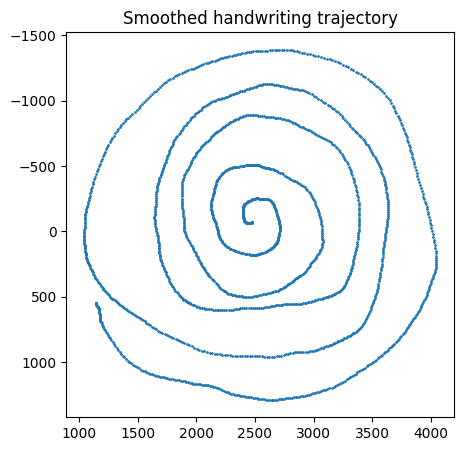

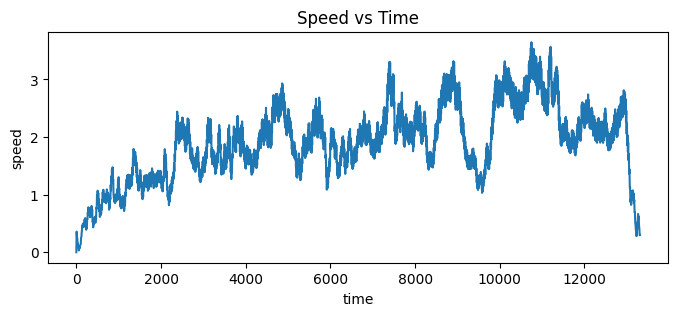

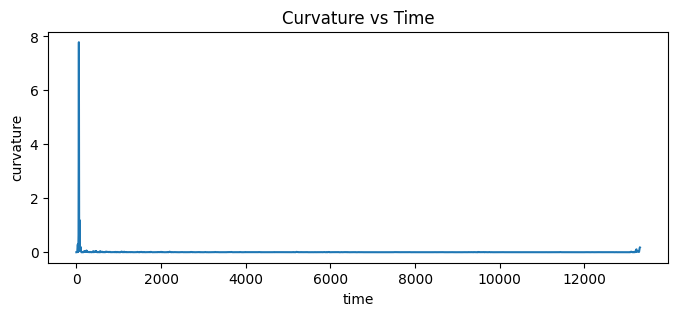

In [6]:
# Trajectory
plt.figure(figsize=(5,5))
plt.plot(df_proc["x_s"], df_proc["y_s"], ".", markersize=2)
plt.gca().invert_yaxis()
plt.title("Smoothed handwriting trajectory")
plt.show()

# Speed
plt.figure(figsize=(8,3))
plt.plot(df_proc["time_s"], df_proc["speed"])
plt.title("Speed vs Time")
plt.xlabel("time")
plt.ylabel("speed")
plt.show()

# Curvature
plt.figure(figsize=(8,3))
plt.plot(df_proc["time_s"], df_proc["curvature"])
plt.title("Curvature vs Time")
plt.xlabel("time")
plt.ylabel("curvature")
plt.show()


In [7]:
pen_strokes = segment_by_pen(df_proc)
print("Number of pen-down strokes:", len(pen_strokes))
print("First 5 strokes:", pen_strokes[:5])


Number of pen-down strokes: 1
First 5 strokes: [(0, 1771)]
